# CORPUS-INFORMED AUTO-TRANSLATOR: VECTOR CREATION NOTEBOOK
Day 3: Converting JSON Document into Semantic Vectors
(Creating vectors from a single corpus item)

**Important note! The jina-embeddings-v3 model used here to create vectors is memory-hungry! To avoid memory crashes in the Google Colab environment, enable T4 GPU in Colab (Runtime → Change runtime type)**

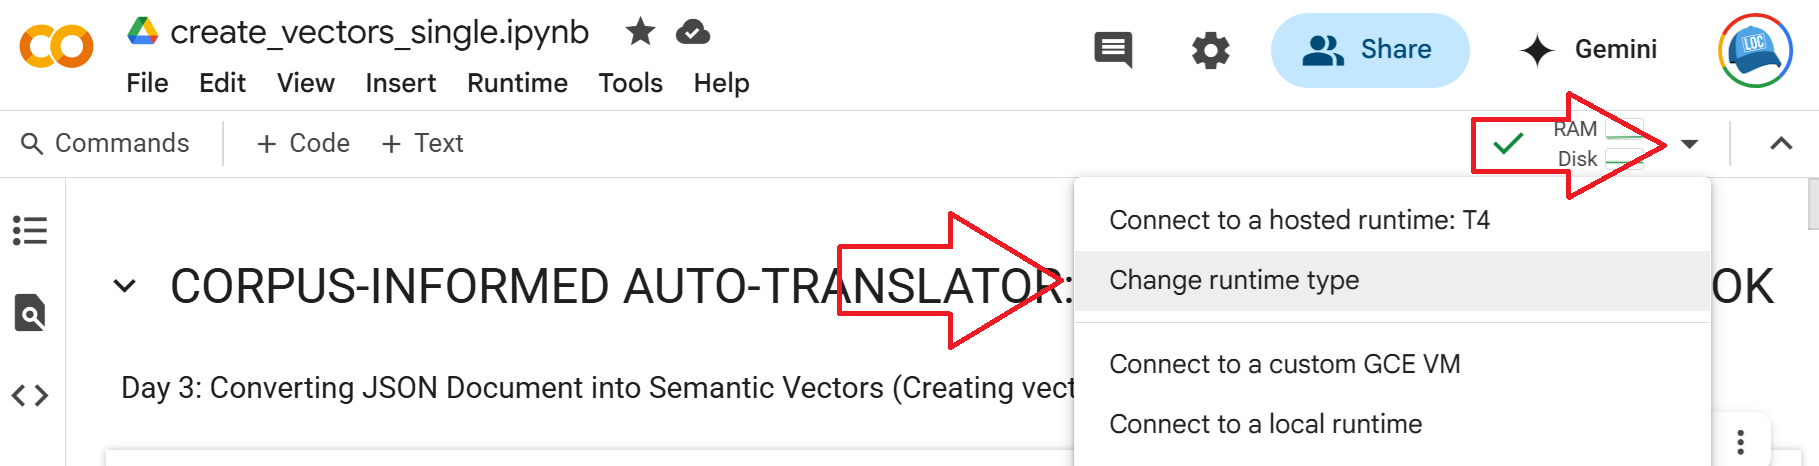

## Notebook Outline

**Part 1: Data Preparation and Planning**

- STEP 1: LOAD THE REQUIRED LIBRARIES
- STEP 2: LOAD AND EXAMINE DATABASE STRUCTURE
- STEP 3: LOAD AND EXAMINE INDIVIDUAL CORPUS ITEM

**Part 2: Function and Model Setup**

- STEP 4: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL (WITH DEMONSTRATION)
- STEP 5: PREPARE THE VECTOR STORAGE STRUCTURE (SCHEMA COMPLIANT)
- STEP 6: DEFINE TEXT EXTRACTION FUNCTIONS
- STEP 7: CREATE VECTORIZATION FUNCTIONS

**Part 3: Execution and Output**
- STEP 8: BATCH PROCESS DOCUMENTS
- STEP 9: VISUALIZE THE VECTORS

## =============================================================================

## Universal Environment Setup

In [1]:
# ==============================================================================
# UNIVERSAL ENVIRONMENT SETUP - WORKS IN BOTH COLAB AND LOCAL
# ==============================================================================
# This cell automatically detects Colab vs Local and sets up everything needed
# Run this FIRST before any other cells!

def setup_environment():
    """Auto-detect and setup environment (Colab or Local)"""
    try:
        import google.colab
        # COLAB SETUP
        print("🌍 Environment detected: COLAB")
        print("🔄 Setting up Colab environment...")

        # Install dependencies
        print("📦 Installing dependencies...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install",
                              "sentence-transformers>=2.7.0", "einops>=0.6.0", "ujson>=5.0.0"])
        print("✅ Dependencies installed")

        # Mount Drive and navigate
        print("🔗 Mounting Google Drive...")
        from google.colab import drive
        drive.mount('/content/drive')

        print("📁 Navigating to project folder...")
        import os
        project_path = '/content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator'
        os.chdir(project_path)
        print(f"📍 Working directory: {os.getcwd()}")

        # Add scripts to path
        import sys
        sys.path.append('./scripts')
        print("✅ Colab setup complete")

    except ImportError:
        # LOCAL SETUP
        print("🌍 Environment detected: LOCAL")
        print("💻 Setting up local environment...")

        # Add to path (handles different folder structures)
        import sys
        if './scripts' not in sys.path:
            sys.path.append('./scripts')
        if '../scripts' not in sys.path:
            sys.path.append('../scripts')

        print("✅ Local setup complete")

# Run the setup
setup_environment()

# Import configuration (works in both environments now)
print("📋 Loading configuration...")
try:
    from config import *
    print("✅ Configuration loaded successfully")

    # Show quick verification
    print(f"✅ Environment: {ENVIRONMENT}")
    print(f"✅ Domain: {DOMAIN}")
    print(f"✅ Languages: {', '.join(LANGUAGES)}")

except ImportError as e:
    print(f"❌ Config import failed: {e}")
    print("💡 Make sure config.py is in the scripts/ folder")

print("\n" + "="*60)
print("🎯 ENVIRONMENT SETUP COMPLETE - Ready for STEP 1!")
print("="*60)

🌍 Environment detected: COLAB
🔄 Setting up Colab environment...
📦 Installing dependencies...
✅ Dependencies installed
🔗 Mounting Google Drive...
Mounted at /content/drive
📁 Navigating to project folder...
📍 Working directory: /content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator
✅ Colab setup complete
📋 Loading configuration...
🌍 Environment detected: COLAB
🔗 Setting up Google Colab environment...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted
📁 Using project structure: /content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator

🔧 UNAM AUTO-TRADUCTOR CONFIGURATION
Environment: colab
Domain: gai
Languages: eng, esp
Model: jinaai/jina-embeddings-v3
Dimensions: 1024
Corpora directory: /content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator/corpora/gai
Vectors directory: /

## Part 1: Data Preparation and Planning

### STEP 1: LOAD THE REQUIRED LIBRARIES

In [2]:
# STEP 1: LOAD THE REQUIRED LIBRARIES

# Core Python libraries
import os
import json
from pathlib import Path
import logging
from typing import Dict, List, Tuple, Optional
from datetime import datetime

# Data processing libraries
import pandas as pd
import numpy as np

# Text processing libraries
import re
from collections import defaultdict

# Machine learning and embedding libraries
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Progress tracking (helpful for long processing times)
from tqdm.notebook import tqdm

# Visualization libraries (for testing our vectors)
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration management
import sys
sys.path.append('../scripts')  # Add scripts folder to path
from config import *  # Import all our configuration settings

# Set up logging for debugging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✅ All libraries loaded successfully!")

# Display current configuration for workshop participants
print("\n" + "="*60)
print("🔧 CURRENT CONFIGURATION SETTINGS")
print("="*60)
print(f"Domain: {DOMAIN}")
print(f"Languages: {', '.join(LANGUAGES)}")
print(f"Model: {MODEL_NAME}")
print(f"Model dimensions: {MODEL_DIMENSIONS}")
print(f"Model task optimization: {MODEL_TASK}")
print(f"Max text length: {MAX_TEXT_LENGTH:,} tokens")
print(f"Create document vectors: {CREATE_DOCUMENT_VECTORS}")
print(f"Create section vectors: {CREATE_SECTION_VECTORS}")
print(f"Create paragraph vectors: {CREATE_PARAGRAPH_VECTORS}")

✅ All libraries loaded successfully!

🔧 CURRENT CONFIGURATION SETTINGS
Domain: gai
Languages: eng, esp
Model: jinaai/jina-embeddings-v3
Model dimensions: 1024
Model task optimization: retrieval.passage
Max text length: 8,000 tokens
Create document vectors: True
Create section vectors: True
Create paragraph vectors: True


### STEP 2: LOAD AND EXAMINE DATABASE STRUCTURE

In [3]:
# STEP 2: LOAD AND EXAMINE DATABASE STRUCTURE

def load_database_file(language):
    """Load the database file for a specific language"""
    database_path = Path(CORPORA_DIR) / language / f"{DOMAIN}-{language}_database.json"

    if not database_path.exists():
        raise FileNotFoundError(f"Database file not found: {database_path}")

    with open(database_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def extract_documents_from_db(db, language):
    """Extract document data from database, handling different structures"""
    documents = {}

    # Get documents from nested 'documents' key
    if 'documents' in db and isinstance(db['documents'], dict):
        nested_docs = {k: v for k, v in db['documents'].items()
                      if k.startswith(f'{DOMAIN}-{language}_item')}
        documents.update(nested_docs)

    # Also check for direct top-level document keys
    top_level_docs = {k: v for k, v in db.items()
                     if k != f'{DOMAIN}_template' and k != 'documents'
                     and k.startswith(f'{DOMAIN}-{language}_item')}
    documents.update(top_level_docs)

    return documents

# Load databases for all languages
print("🔍 Loading corpus databases...")

databases = {}
all_documents = {}
failed_languages = []

for language in LANGUAGES:
    try:
        databases[language] = load_database_file(language)
        all_documents[language] = extract_documents_from_db(databases[language], language)
        print(f"✅ {language.upper()}: {len(all_documents[language])} documents loaded")

        # Show all document IDs and titles for this language
        if all_documents[language]:
            print(f"   All document IDs:")
            for i, (doc_id, doc_data) in enumerate(all_documents[language].items(), 1):
                title = doc_data.get('document_metadata', {}).get('title', 'No title')
                print(f"     {i:2d}. {doc_id}: {title[:60]}{'...' if len(title) > 60 else ''}")
        print()  # Add blank line between languages

    except FileNotFoundError as e:
        failed_languages.append(language)
        print(f"❌ {language.upper()}: Database not found")

# Show overall results
total_documents = sum(len(docs) for docs in all_documents.values())
print(f"📊 Total: {total_documents} documents across {len(databases)} languages")

# Create summary for easy access by later steps
document_summary = {
    'total_count': total_documents,
    'by_language': {lang: len(docs) for lang, docs in all_documents.items()},
    'all_documents': all_documents
}

print(f"✅ Database loading complete! Ready for vectorization.")

# Only show errors if any occurred
if failed_languages:
    print(f"\n⚠️  Failed to load: {', '.join(failed_languages)}")
    for lang in failed_languages:
        expected_path = Path(CORPORA_DIR) / lang / f"{DOMAIN}-{lang}_database.json"
        print(f"   Expected: {expected_path}")

🔍 Loading corpus databases...
✅ ENG: 4 documents loaded
   All document IDs:
      1. gai-eng_item001: Attention is All You Need
      2. gai-eng_item002: On the Dangers of Stochastic Parrots: Can Language Models Be...
      3. gai-eng_item003: Recommendation on the Ethics of Artificial Intelligence
      4. gai-eng_item004: The Age of AI has begun

✅ ESP: 2 documents loaded
   All document IDs:
      1. gai-esp_item001: Propuesta de Agenda Nacional de la Inteligencia Artificial p...
      2. gai-esp_item002: Conversando con una computadora: ¿Cómo entienden las intelig...

📊 Total: 6 documents across 2 languages
✅ Database loading complete! Ready for vectorization.


### STEP 3: LOAD AND EXAMINE INDIVIDUAL CORPUS ITEM

In [4]:
# STEP 3: LOAD AND EXAMINE INDIVIDUAL CORPUS ITEM

def load_corpus_item(language, item_id):
    """Load a specific corpus item JSON file (content only)"""
    item_path = Path(CORPORA_DIR) / language / "processed" / f"{item_id}.json"

    if not item_path.exists():
        raise FileNotFoundError(f"Corpus item not found: {item_path}")

    with open(item_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def get_document_metadata(databases, language, item_id):
    """Get metadata for a document from the database"""
    db = databases.get(language, {})
    documents = db.get('documents', {})
    return documents.get(item_id, {})

def merge_content_and_metadata(content_data, metadata):
    """Merge content and metadata into a complete document object"""
    return {
        'document_id': content_data.get('document_id'),
        'document_metadata': metadata.get('document_metadata', {}),
        'processing_metadata': metadata.get('processing_metadata', {}),
        'content': content_data.get('content', {})
    }

def analyze_corpus_structure(corpus_item):
    """Analyze document structure for vectorization planning"""
    analysis = {
        'document_id': corpus_item.get('document_id', 'Unknown'),
        'title': corpus_item.get('document_metadata', {}).get('title', 'No title'),
        'language': corpus_item.get('document_metadata', {}).get('language_family', 'Unknown'),  # FIXED: Use language_family
        'text_type': corpus_item.get('document_metadata', {}).get('text_type', 'Unknown'),
        'word_count': corpus_item.get('processing_metadata', {}).get('word_count', 0),
        'has_abstract': bool(corpus_item.get('content', {}).get('abstract')),
        'abstract_length': len(corpus_item.get('content', {}).get('abstract', '')),
        'sections': [],
        'total_paragraphs': 0,
        'total_subsections': 0,
        'total_subsubsections': 0,
        'total_text_length': 0
    }

    # Analyze sections and count all structural elements
    content = corpus_item.get('content', {})
    sections = content.get('sections', [])

    for section in sections:
        section_info = {
            'title': section.get('title', 'No title'),
            'main_paragraphs': len(section.get('paragraphs', [])),
            'subsections': [],
            'total_section_paragraphs': 0
        }

        # Count main section paragraphs
        section_info['total_section_paragraphs'] += section_info['main_paragraphs']
        analysis['total_paragraphs'] += section_info['main_paragraphs']

        # Calculate text length
        for paragraph in section.get('paragraphs', []):
            analysis['total_text_length'] += len(paragraph.get('text', ''))

        # Process subsections
        for subsection in section.get('subsections', []):
            subsection_paragraphs = len(subsection.get('paragraphs', []))
            section_info['total_section_paragraphs'] += subsection_paragraphs
            analysis['total_paragraphs'] += subsection_paragraphs
            analysis['total_subsections'] += 1

            # Add text length
            for paragraph in subsection.get('paragraphs', []):
                analysis['total_text_length'] += len(paragraph.get('text', ''))

            # Count subsubsections
            subsubsections = subsection.get('subsubsections', [])
            for subsubsection in subsubsections:
                subsubsection_paragraphs = len(subsubsection.get('paragraphs', []))
                section_info['total_section_paragraphs'] += subsubsection_paragraphs
                analysis['total_paragraphs'] += subsubsection_paragraphs
                analysis['total_subsubsections'] += 1

                # Add text length
                for paragraph in subsubsection.get('paragraphs', []):
                    analysis['total_text_length'] += len(paragraph.get('text', ''))

        analysis['sections'].append(section_info)

    # Add abstract to total text length
    analysis['total_text_length'] += analysis['abstract_length']

    return analysis

def display_analysis(analysis):
    """Display streamlined analysis for workshop"""

    print(f"\n📊 DOCUMENT ANALYSIS")
    print(f"🔖 {analysis['document_id']}: {analysis['title']}")
    print(f"🌐 Language: {analysis['language'].upper()}")
    print(f"📄 Type: {analysis['text_type']}")
    print(f"📏 {analysis['word_count']:,} words | {analysis['total_text_length']:,} characters")

    print(f"\n📋 STRUCTURE SUMMARY")
    print(f"📝 Abstract: {'✅' if analysis['has_abstract'] else '❌'} ({analysis['abstract_length']:,} chars)")
    print(f"📚 Sections: {len(analysis['sections'])}")
    print(f"📂 Subsections: {analysis['total_subsections']}")
    print(f"🔗 Sub-subsections: {analysis['total_subsubsections']}")
    print(f"📝 Total paragraphs: {analysis['total_paragraphs']}")

    print(f"\n📑 SECTION OVERVIEW")
    for i, section in enumerate(analysis['sections'], 1):
        title = section['title'][:40] + '...' if len(section['title']) > 40 else section['title']
        print(f"  {i:2d}. {title} ({section['total_section_paragraphs']} paragraphs)")

    print(f"\n🎯 VECTORIZATION PLAN")
    document_vectors = 1
    section_vectors = len(analysis['sections'])
    subsection_vectors = analysis['total_subsections']
    subsubsection_vectors = analysis['total_subsubsections']
    paragraph_vectors = analysis['total_paragraphs']
    total_vectors = document_vectors + section_vectors + subsection_vectors + subsubsection_vectors + paragraph_vectors

    print(f"📄 Document level: {document_vectors}")
    print(f"📚 Section level: {section_vectors}")
    print(f"📂 Subsection level: {subsection_vectors}")
    print(f"🔗 Sub-subsection level: {subsubsection_vectors}")
    print(f"📝 Paragraph level: {paragraph_vectors}")
    print(f"🎯 Total vectors: {total_vectors}")

# Load and analyze test document
test_doc_id = "gai-eng_item001"
test_language = "eng"

print(f"📖 Loading corpus item: {test_doc_id}")

try:
    # Load content and metadata
    content_data = load_corpus_item(test_language, test_doc_id)

    if test_language in databases:
        metadata = get_document_metadata(databases, test_language, test_doc_id)
        corpus_item = merge_content_and_metadata(content_data, metadata)

        # Analyze and display
        analysis = analyze_corpus_structure(corpus_item)
        display_analysis(analysis)

        print(f"\n✅ Document analysis complete! Ready for vectorization.")

    else:
        print(f"❌ Database for {test_language} not loaded")

except FileNotFoundError as e:
    print(f"❌ File not found: {test_doc_id}.json")
    print(f"💡 Expected location: {Path(CORPORA_DIR) / test_language / 'processed' / f'{test_doc_id}.json'}")
except Exception as e:
    print(f"❌ Error: {e}")

# Store analysis for next steps
if 'analysis' in locals():
    test_document_analysis = analysis
    print(f"\n📋 Analysis stored as 'test_document_analysis' for next steps")

📖 Loading corpus item: gai-eng_item001

📊 DOCUMENT ANALYSIS
🔖 gai-eng_item001: Attention is All You Need
🌐 Language: ENG
📄 Type: Academic paper
📏 5,817 words | 24,391 characters

📋 STRUCTURE SUMMARY
📝 Abstract: ✅ (1,139 chars)
📚 Sections: 7
📂 Subsections: 12
🔗 Sub-subsections: 3
📝 Total paragraphs: 69

📑 SECTION OVERVIEW
   1. Introduction (4 paragraphs)
   2. Background (4 paragraphs)
   3. Model Architecture (29 paragraphs)
   4. 4 Why Self-Attention (6 paragraphs)
   5. Training (9 paragraphs)
   6. Results (12 paragraphs)
   7. 7 Conclusion (5 paragraphs)

🎯 VECTORIZATION PLAN
📄 Document level: 1
📚 Section level: 7
📂 Subsection level: 12
🔗 Sub-subsection level: 3
📝 Paragraph level: 69
🎯 Total vectors: 92

✅ Document analysis complete! Ready for vectorization.

📋 Analysis stored as 'test_document_analysis' for next steps


## =============================================================================

## Part 2: Function and Model Setup

### STEP 4: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL

In [5]:
# STEP 4: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL
# Block 1: Load the model

print("🤖 Loading multilingual embedding model...")
print("📥 This may take a moment on first run as it downloads the model (~1.1GB)")

try:
    # Load the cross-lingual model (UPDATED TO JINA-V3!)
    model = SentenceTransformer('jinaai/jina-embeddings-v3', trust_remote_code=True)
    print("✅ Model loaded successfully!")

    # Display model information
    print(f"\n📊 MODEL INFORMATION")
    print(f"🏷️  Model: jina-embeddings-v3")
    print(f"📐 Embedding dimension: {model.get_sentence_embedding_dimension()}")
    print(f"📏 Max sequence length: {model.max_seq_length}")
    print(f"🌐 Cross-lingual: Maps 89 languages (including Spanish + English) to same vector space")
    print(f"⚡ Advanced: 570M parameters with task-specific LoRA adapters")
    print(f"🎯 Task optimization: Available for retrieval, classification, clustering")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("💡 Troubleshooting:")
    print("   1. Check internet connection (model downloads from Hugging Face)")
    print("   2. Ensure sentence-transformers>=2.7.0: pip install -U sentence-transformers")
    print("   3. Python compatibility: Requires trust_remote_code=True")
    print("   4. Try restarting kernel if you see cache issues")

🤖 Loading multilingual embedding model...
📥 This may take a moment on first run as it downloads the model (~1.1GB)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/734k [00:00<?, ?B/s]

custom_st.py:   0%|          | 0.00/8.78k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-embeddings-v3:
- custom_st.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

configuration_xlm_roberta.py:   0%|          | 0.00/6.54k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- configuration_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_lora.py:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

modeling_xlm_roberta.py:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

mlp.py:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mlp.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


xlm_padding.py:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


embedding.py:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mha.py:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

rotary.py:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mha.py
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


block.py:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

stochastic_depth.py:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- block.py
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_xlm_roberta.py
- mlp.py
- xlm_padding.py
- embedding.py
- mha.py
- block.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was down

model.safetensors:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/192 [00:00<?, ?B/s]

✅ Model loaded successfully!

📊 MODEL INFORMATION
🏷️  Model: jina-embeddings-v3
📐 Embedding dimension: 1024
📏 Max sequence length: 8194
🌐 Cross-lingual: Maps 89 languages (including Spanish + English) to same vector space
⚡ Advanced: 570M parameters with task-specific LoRA adapters
🎯 Task optimization: Available for retrieval, classification, clustering


In [7]:
# GPU & MEMORY DIAGNOSTIC (Run after STEP 4 - Model Loading)

import torch
import psutil

print("🔧 SYSTEM DIAGNOSTICS")
print("=" * 50)

# GPU Check
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"✅ GPU available: {gpu_name}")
    print(f"📊 GPU memory: {gpu_memory:.1f} GB")

    # Check if model is on GPU (correct syntax for SentenceTransformer)
    try:
        # SentenceTransformer models have a _modules attribute
        device = next(model._modules['0'].parameters()).device
        print(f"🎯 Model device: {device}")

        if device.type == 'cuda':
            print("✅ Model is using GPU acceleration!")
        else:
            print("⚠️ Model is on CPU - should move to GPU for better performance")

    except Exception as e:
        print(f"ℹ️ Cannot determine model device: {e}")
        print("💡 Model will automatically use GPU for inference when available")

else:
    print("❌ No GPU available")
    print("💡 Enable: Runtime → Change runtime type → GPU")

# RAM Check
memory = psutil.virtual_memory()
print(f"🧠 System RAM: {memory.percent:.1f}% used ({memory.used/1024**3:.1f}/{memory.total/1024**3:.1f} GB)")

if memory.percent > 80:
    print("⚠️ High RAM usage - consider GPU acceleration")
else:
    print("✅ RAM usage looks good")

# Quick GPU test
if torch.cuda.is_available():
    print(f"\n🧪 GPU Test:")
    test_tensor = torch.randn(1000, 1000).cuda()
    result = torch.matmul(test_tensor, test_tensor)
    print(f"✅ GPU computation test passed!")
    del test_tensor, result
    torch.cuda.empty_cache()

print("=" * 50)

🔧 SYSTEM DIAGNOSTICS
✅ GPU available: Tesla T4
📊 GPU memory: 14.7 GB
ℹ️ Cannot determine model device: '0'
💡 Model will automatically use GPU for inference when available
🧠 System RAM: 23.1% used (2.6/12.7 GB)
✅ RAM usage looks good

🧪 GPU Test:
✅ GPU computation test passed!


#### DEMONSTRATION: UNIFIED VECTOR SPACE FOR BILINGUAL CONTENT

In [8]:
# STEP 4: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL
# Block 2: Demonstrate the unified vector space

print("\n🌐 DEMONSTRATING UNIFIED VECTOR SPACE:")
print("=" * 60)

# Test sentences in English and Spanish (related to your corpus domain)
test_sentences = [
    "Artificial intelligence is transforming education worldwide",  # English
    "La inteligencia artificial está transformando la educación mundial",  # Spanish (same meaning)
    "Machine learning algorithms require large datasets for training",  # English
    "Los algoritmos de aprendizaje automático requieren grandes conjuntos de datos",  # Spanish (same meaning)
    "The weather forecast shows rain tomorrow",  # English (unrelated topic)
    "El pronóstico del tiempo muestra lluvia mañana"  # Spanish (unrelated topic)
]

# Create embeddings (with normalization for better similarity comparisons)
print("🔄 Creating embeddings for test sentences...")
test_embeddings = model.encode(test_sentences, normalize_embeddings=True)
print(f"✅ Generated {len(test_embeddings)} embeddings of {test_embeddings[0].shape[0]} dimensions each")

# Calculate similarity between English and Spanish pairs
print("\n📈 SIMILARITY SCORES (0-1, higher = more similar):")
print("-" * 60)

# Compare sentence pairs
for i in range(0, len(test_sentences), 2):
    eng_sentence = test_sentences[i]
    spa_sentence = test_sentences[i+1]

    similarity = cosine_similarity(
        test_embeddings[i].reshape(1, -1),
        test_embeddings[i+1].reshape(1, -1)
    )[0][0]

    print(f"\n🔤 English: '{eng_sentence[:45]}...'")
    print(f"🔤 Spanish: '{spa_sentence[:45]}...'")
    print(f"📊 Similarity: {similarity:.4f} {'✅ High cross-lingual similarity!' if similarity > 0.7 else '⚠️  Lower similarity'}")

# Show that unrelated sentences have lower similarity
print(f"\n🔍 CROSS-TOPIC COMPARISON (unrelated content):")
unrelated_sim = cosine_similarity(
    test_embeddings[0].reshape(1, -1),  # AI sentence in English
    test_embeddings[4].reshape(1, -1)   # Weather sentence in English
)[0][0]
print(f"'AI education...' vs 'Weather forecast...': {unrelated_sim:.4f}")
print(f"💡 Notice how related topics have higher similarity than unrelated ones!")

if test_embeddings[0].shape[0] == 1024:
    print(f"\n✅ READY FOR CORPUS VECTORIZATION")
    print(f"📋 Model will create 1024-dimensional vectors for your authentic corpora")
    print(f"🎯 Using 'retrieval.passage' task optimization for corpus indexing")
else:
    print(f"\n⚠️  Unexpected embedding dimension: {test_embeddings[0].shape[0]}")
    print(f"Expected: 1024 dimensions for jina-embeddings-v3")


🌐 DEMONSTRATING UNIFIED VECTOR SPACE:
🔄 Creating embeddings for test sentences...
✅ Generated 6 embeddings of 1024 dimensions each

📈 SIMILARITY SCORES (0-1, higher = more similar):
------------------------------------------------------------

🔤 English: 'Artificial intelligence is transforming educa...'
🔤 Spanish: 'La inteligencia artificial está transformando...'
📊 Similarity: 0.9335 ✅ High cross-lingual similarity!

🔤 English: 'Machine learning algorithms require large dat...'
🔤 Spanish: 'Los algoritmos de aprendizaje automático requ...'
📊 Similarity: 0.8607 ✅ High cross-lingual similarity!

🔤 English: 'The weather forecast shows rain tomorrow...'
🔤 Spanish: 'El pronóstico del tiempo muestra lluvia mañan...'
📊 Similarity: 0.8408 ✅ High cross-lingual similarity!

🔍 CROSS-TOPIC COMPARISON (unrelated content):
'AI education...' vs 'Weather forecast...': 0.3841
💡 Notice how related topics have higher similarity than unrelated ones!

✅ READY FOR CORPUS VECTORIZATION
📋 Model will create 


📊 VISUALIZING THE UNIFIED VECTOR SPACE:
🔄 Reducing 1024 dimensions to 2D for visualization...
🔗 Drawing connections between translation pairs...


<ipython-input-9-5e7b317c0429>:58: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-5e7b317c0429>:58: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-5e7b317c0429>:58: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127466 (

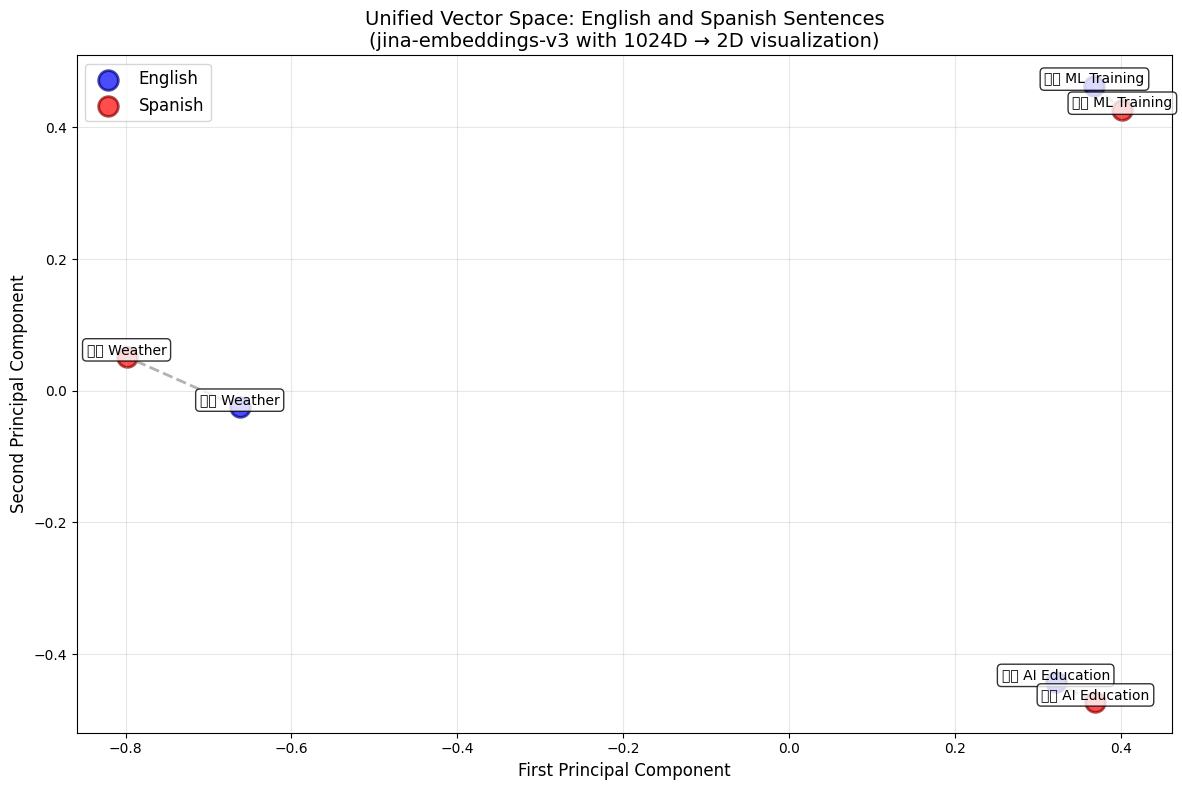


💡 KEY OBSERVATIONS:
🔗 Translation pairs (connected by lines) cluster together
📊 Similar topics group near each other regardless of language
🌐 jina-embeddings-v3 demonstrates superior multilingual alignment!
🎯 Enhanced performance with 570M parameters and LoRA task adapters

✅ MODEL READY FOR CORPUS VECTORIZATION
📋 Your authentic Spanish and English texts will map to this same unified space
📐 Each document will be represented as a 1024-dimensional vector


In [9]:
# STEP 4: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL
# Block 3: Visualize the unified vector space

print("\n📊 VISUALIZING THE UNIFIED VECTOR SPACE:")
print("=" * 60)

# Reduce dimensions for visualization
print("🔄 Reducing 1024 dimensions to 2D for visualization...")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(test_embeddings)

# Create visualization
plt.figure(figsize=(12, 8))

# Plot English sentences (blue)
eng_indices = list(range(0, len(test_sentences), 2))
plt.scatter(embeddings_2d[eng_indices, 0], embeddings_2d[eng_indices, 1],
           c='blue', s=200, alpha=0.7, label='English', edgecolors='navy', linewidth=2)

# Plot Spanish sentences (red)
spa_indices = list(range(1, len(test_sentences), 2))
plt.scatter(embeddings_2d[spa_indices, 0], embeddings_2d[spa_indices, 1],
           c='red', s=200, alpha=0.7, label='Spanish', edgecolors='darkred', linewidth=2)

# Add labels for each point
for i, sentence in enumerate(test_sentences):
    # Shorten text for display
    if 'inteligencia artificial' in sentence or 'Artificial intelligence' in sentence:
        display_text = "AI Education"
    elif 'aprendizaje automático' in sentence or 'Machine learning' in sentence:
        display_text = "ML Training"
    elif 'tiempo' in sentence or 'weather' in sentence:
        display_text = "Weather"
    else:
        display_text = sentence[:20] + "..."

    # Add language indicator
    lang = "🇪🇸" if i % 2 == 1 else "🇺🇸"
    display_text = f"{lang} {display_text}"

    plt.annotate(display_text,
                (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                fontsize=10, ha='center', va='bottom',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Draw lines between translation pairs
print("🔗 Drawing connections between translation pairs...")
for i in range(0, len(test_sentences), 2):
    plt.plot([embeddings_2d[i, 0], embeddings_2d[i+1, 0]],
             [embeddings_2d[i, 1], embeddings_2d[i+1, 1]],
             'gray', linestyle='--', alpha=0.6, linewidth=2)

plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.title('Unified Vector Space: English and Spanish Sentences\n(jina-embeddings-v3 with 1024D → 2D visualization)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n💡 KEY OBSERVATIONS:")
print(f"🔗 Translation pairs (connected by lines) cluster together")
print(f"📊 Similar topics group near each other regardless of language")
print(f"🌐 jina-embeddings-v3 demonstrates superior multilingual alignment!")
print(f"🎯 Enhanced performance with 570M parameters and LoRA task adapters")
print(f"\n✅ MODEL READY FOR CORPUS VECTORIZATION")
print(f"📋 Your authentic Spanish and English texts will map to this same unified space")
print(f"📐 Each document will be represented as a 1024-dimensional vector")

### STEP 5: PREPARE THE VECTOR STORAGE STRUCTURE (SCHEMA COMPLIANT)

Note: Consider adding "text_length" to vector structure in a future iteration

In [10]:
# STEP 5: PREPARE THE VECTOR STORAGE STRUCTURE (SCHEMA COMPLIANT)

print("📦 PREPARING VECTOR STORAGE STRUCTURE")
print("=" * 60)

print("✅ Using standardized schema for vector storage")
print("📋 Schema structure:")
print("  • metadata: Model name, dimensions, task optimization, and normalization")
print("  • vectors: Array of vector objects with:")
print("    - Document vectors: id, title, count, created, vector, text")
print("    - Section vectors: id, document_id, title, level, count, created, vector, text")
print("    - Paragraph vectors: id, document_id, count, created, vector, text")
print("  • Full text content stored (no length limitations)")

def create_metadata(model):
    """Create standardized metadata for vector files"""
    return {
        "model": MODEL_NAME,
        "dimension": model.get_sentence_embedding_dimension(),
        "task_optimization": MODEL_TASK,
        "normalized": True,
        "created": datetime.now().isoformat(),
        "environment": ENVIRONMENT
    }

def save_document_vectors_json(vectors_data, filename, model):
    """Save document vectors to JSON file following the standardized schema"""

    vector_objects = []

    for i, vector_info in enumerate(vectors_data, 1):
        vector_obj = {
            "id": vector_info['id'],  # document_id
            "title": vector_info.get('title', 'No title'),
            "count": i,
            "created": datetime.now().isoformat(),
            "text": vector_info.get('text', ''),  # Full text, no truncation
            "vector": vector_info['vector'].tolist() if hasattr(vector_info['vector'], 'tolist') else vector_info['vector']
        }
        vector_objects.append(vector_obj)

    # Create the complete data structure following schema
    vector_data = {
        "metadata": create_metadata(model),
        "vectors": vector_objects
    }

    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(vector_data, f, ensure_ascii=False, indent=2)

    print(f"💾 Saved {len(vector_objects)} document vectors to {filename}")

def save_section_vectors_json(vectors_data, filename, model):
    """Save section vectors to JSON file following the standardized schema"""

    vector_objects = []

    for i, vector_info in enumerate(vectors_data, 1):
        vector_obj = {
            "id": vector_info['id'],  # section_id
            "document_id": vector_info['document_id'],
            "title": vector_info.get('title', 'No title'),
            "level": vector_info.get('level', 0),
            "count": i,
            "created": datetime.now().isoformat(),
            "text": vector_info.get('text', ''),  # Full text, no truncation
            "vector": vector_info['vector'].tolist() if hasattr(vector_info['vector'], 'tolist') else vector_info['vector']
        }
        vector_objects.append(vector_obj)

    # Create the complete data structure following schema
    vector_data = {
        "metadata": create_metadata(model),
        "vectors": vector_objects
    }

    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(vector_data, f, ensure_ascii=False, indent=2)

    print(f"💾 Saved {len(vector_objects)} section vectors to {filename}")

def save_paragraph_vectors_json(vectors_data, filename, model):
    """Save paragraph vectors to JSON file following the standardized schema"""

    vector_objects = []

    for i, vector_info in enumerate(vectors_data, 1):
        vector_obj = {
            "id": vector_info['id'],  # paragraph_id
            "document_id": vector_info['document_id'],
            "count": i,
            "created": datetime.now().isoformat(),
            "text": vector_info.get('text', ''),  # Full text, no truncation
            "vector": vector_info['vector'].tolist() if hasattr(vector_info['vector'], 'tolist') else vector_info['vector']
        }
        vector_objects.append(vector_obj)

    # Create the complete data structure following schema
    vector_data = {
        "metadata": create_metadata(model),
        "vectors": vector_objects
    }

    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(vector_data, f, ensure_ascii=False, indent=2)

    print(f"💾 Saved {len(vector_objects)} paragraph vectors to {filename}")

def save_all_vectors_with_schema(vectors, extracted_content, model, output_dir):
    """
    Convenience function to save all vectors using the standardized schema format

    Args:
        vectors: Dictionary containing all vector data from create_vectors()
        extracted_content: Content data from extract_document_content()
        model: SentenceTransformer model
        output_dir: Directory to save vector files
    """

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # 1. Save document vectors
    document_vectors_data = [{
        'id': vectors['document_id'],
        'title': extracted_content['title'],
        'text': extracted_content['document_text'],  # Full document text
        'vector': vectors['document_vector']['vector']
    }]

    save_document_vectors_json(
        vectors_data=document_vectors_data,
        filename=os.path.join(output_dir, DOCUMENT_VECTORS_FILE),
        model=model
    )

    # 2. Save section vectors
    section_vectors_data = []
    for section_vec in vectors['section_vectors']:
        section_vectors_data.append({
            'id': section_vec['id'],
            'document_id': section_vec['document_id'],
            'title': section_vec['title'],
            'level': section_vec['level'],
            'text': section_vec['text'],  # Full section text
            'vector': section_vec['vector']
        })

    save_section_vectors_json(
        vectors_data=section_vectors_data,
        filename=os.path.join(output_dir, SECTION_VECTORS_FILE),
        model=model
    )

    # 3. Save paragraph vectors
    paragraph_vectors_data = []
    for para_vec in vectors['paragraph_vectors']:
        paragraph_vectors_data.append({
            'id': para_vec['id'],
            'document_id': para_vec['document_id'],
            'text': para_vec['text'],  # Full paragraph text
            'vector': para_vec['vector']
        })

    save_paragraph_vectors_json(
        vectors_data=paragraph_vectors_data,
        filename=os.path.join(output_dir, PARAGRAPH_VECTORS_FILE),
        model=model
    )

    print(f"\n✅ All vectors saved to: {output_dir}")
    print("📁 Schema-compliant files created:")
    print(f"  • {DOCUMENT_VECTORS_FILE} (full document text + vectors)")
    print(f"  • {SECTION_VECTORS_FILE} (full section text + vectors)")
    print(f"  • {PARAGRAPH_VECTORS_FILE} (full paragraph text + vectors)")
    print(f"📐 Vector dimension: {model.get_sentence_embedding_dimension()}")
    print(f"🎯 Model: {MODEL_NAME}")
    print(f"🔧 Task optimization: {MODEL_TASK}")
    print(f"✨ Normalized embeddings: Yes")

print("\n✅ VECTOR STORAGE FUNCTIONS READY")
print("📋 Available functions:")
print("  • save_document_vectors_json() - Save document-level vectors")
print("  • save_section_vectors_json() - Save section-level vectors")
print("  • save_paragraph_vectors_json() - Save paragraph-level vectors")
print("  • save_all_vectors_with_schema() - Save all vector types at once")
print("\n💡 All functions store complete text content without truncation")
print(f"📊 Enhanced metadata includes: model, dimensions, task, normalization, environment")

📦 PREPARING VECTOR STORAGE STRUCTURE
✅ Using standardized schema for vector storage
📋 Schema structure:
  • metadata: Model name, dimensions, task optimization, and normalization
  • vectors: Array of vector objects with:
    - Document vectors: id, title, count, created, vector, text
    - Section vectors: id, document_id, title, level, count, created, vector, text
    - Paragraph vectors: id, document_id, count, created, vector, text
  • Full text content stored (no length limitations)

✅ VECTOR STORAGE FUNCTIONS READY
📋 Available functions:
  • save_document_vectors_json() - Save document-level vectors
  • save_section_vectors_json() - Save section-level vectors
  • save_paragraph_vectors_json() - Save paragraph-level vectors
  • save_all_vectors_with_schema() - Save all vector types at once

💡 All functions store complete text content without truncation
📊 Enhanced metadata includes: model, dimensions, task, normalization, environment


### STEP 6: DEFINE TEXT EXTRACTION FUNCTIONS

In [12]:
# STEP 6: DEFINE TEXT EXTRACTION FUNCTIONS
# Block 1: Define paragraph extraction functions

def extract_clean_text(text, include_citations=True):
    """
    Clean text for vectorization while preserving meaning

    Args:
        text: Raw text string
        include_citations: Whether to keep citation markers like [1] in the text

    Returns:
        Cleaned text string
    """
    if not text:
        return ""

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Remove citation markers if requested
    if not include_citations:
        # Remove patterns like [1], [2,3], [14-16], etc.
        text = re.sub(r'\[\d+(?:[-,]\d+)*\]', '', text)

    # Remove excessive punctuation but keep sentence structure
    text = re.sub(r'\.{2,}', '.', text)  # Multiple periods to single
    text = re.sub(r'\s+([.,!?;:])', r'\1', text)  # Remove space before punctuation

    return text.strip()

def extract_equation_text(paragraph_data):
    """
    Extract readable text from equations in a paragraph

    Args:
        paragraph_data: Dictionary containing paragraph information

    Returns:
        String with equation descriptions
    """
    equation_texts = []

    # Check for inline equations
    if 'inline_equations' in paragraph_data:
        for eq in paragraph_data['inline_equations']:
            if 'text' in eq:
                equation_texts.append(eq['text'])

    # Check for equation numbers
    if 'equation_numbers' in paragraph_data:
        for eq in paragraph_data['equation_numbers']:
            if 'text' in eq:
                equation_texts.append(f"Equation {eq['text']}")

    return ' '.join(equation_texts)

def extract_paragraph_text(paragraph):
    """
    Extract complete text from a paragraph including equations

    Args:
        paragraph: Paragraph dictionary from JSON

    Returns:
        Tuple of (paragraph_id, full_text)
    """
    paragraph_id = paragraph.get('id', 'unknown')

    # Get main text
    main_text = paragraph.get('text', '')

    # Add equation text if present
    equation_text = extract_equation_text(paragraph)
    if equation_text:
        main_text = f"{main_text} {equation_text}"

    # Clean the combined text
    clean_text = extract_clean_text(main_text)

    return paragraph_id, clean_text

In [13]:
# STEP 6: DEFINE TEXT EXTRACTION FUNCTIONS
# Block 2: Define section extraction functions

def extract_section_content(section, parent_id="", level=0):
    """
    Recursively extract all text content from a section and its subsections

    Args:
        section: Section dictionary from JSON
        parent_id: Parent section ID for hierarchical tracking
        level: Current nesting level (0=main, 1=sub, 2=subsub)

    Returns:
        Dictionary with section text and list of all paragraphs
    """
    section_id = section.get('id', 'unknown')
    section_title = section.get('title', '')

    # Build simpler section ID based on level
    if level == 0:
        full_section_id = section_id
    else:
        full_section_id = f"{parent_id}_{section_id.split('_')[-1]}"

    # Collect all text for this section level
    section_texts = []
    all_paragraphs = []
    subsection_results = []

    # Add section title
    if section_title:
        section_texts.append(section_title)

    # Extract main section paragraphs
    for paragraph in section.get('paragraphs', []):
        para_id, para_text = extract_paragraph_text(paragraph)
        if para_text:
            section_texts.append(para_text)
            all_paragraphs.append({
                'id': para_id,
                'text': para_text,
                'section_id': full_section_id,
                'section_title': section_title,
                'level': level
            })

    # Process subsections recursively
    for subsection in section.get('subsections', []):
        subsection_content = extract_section_content(subsection, full_section_id, level + 1)
        subsection_results.append(subsection_content)
        section_texts.append(subsection_content['section_text'])
        all_paragraphs.extend(subsection_content['all_paragraphs'])

        # Process subsubsections within each subsection
        for subsubsection in subsection.get('subsubsections', []):
            subsubsection_content = extract_section_content(
                subsubsection,
                f"{full_section_id}_{subsection['id'].split('_')[-1]}",
                level + 2
            )
            subsection_results.append(subsubsection_content)
            section_texts.append(subsubsection_content['section_text'])
            all_paragraphs.extend(subsubsection_content['all_paragraphs'])

    # Combine all text for this section
    combined_section_text = ' '.join(section_texts)

    return {
        'section_id': full_section_id,
        'section_title': section_title,
        'section_text': combined_section_text,
        'subsections': subsection_results,
        'all_paragraphs': all_paragraphs,
        'level': level
    }

In [14]:
# STEP 6: DEFINE TEXT EXTRACTION FUNCTIONS
# Block 3: Define document extraction functions

def extract_document_content(corpus_item):
    """
    Extract all text content from a corpus document at all levels
    """
    print(f"📄 Extracting content from: {corpus_item.get('document_id', 'Unknown')}")

    # Initialize containers
    document_texts = []
    all_sections = []
    all_paragraphs = []

    # Extract metadata
    metadata = corpus_item.get('document_metadata', {})
    doc_id = corpus_item.get('document_id', 'unknown')
    title = metadata.get('title', '')
    language = metadata.get('language_variant', 'unknown')

    # Add title to document text
    if title:
        document_texts.append(title)

    # Extract abstract if present
    content = corpus_item.get('content', {})
    abstract = content.get('abstract', '')
    if abstract:
        clean_abstract = extract_clean_text(abstract)
        document_texts.append(clean_abstract)
        all_paragraphs.append({
            'id': f"{doc_id}_abstract",
            'document_id': doc_id,
            'text': clean_abstract,
            'section_id': 'abstract',
            'section_title': 'Abstract',
            'level': -1  # Special level for abstract
        })

    # Process all main sections
    for section in content.get('sections', []):
        section_content = extract_section_content(section, "", 0)

        # Add to document text
        document_texts.append(section_content['section_text'])

        # Recursive function to collect all sections at all levels
        def collect_sections(section_data):
            all_sections.append({
                'id': section_data['section_id'],
                'document_id': doc_id,
                'title': section_data['section_title'],
                'text': section_data['section_text'],
                'level': section_data['level']
            })
            for subsection in section_data['subsections']:
                collect_sections(subsection)

        collect_sections(section_content)

        # Update all paragraphs to include document_id
        for paragraph in section_content['all_paragraphs']:
            paragraph['document_id'] = doc_id

        # Collect all paragraphs
        all_paragraphs.extend(section_content['all_paragraphs'])

    # Combine all text for document level
    full_document_text = ' '.join(document_texts)

    # Calculate statistics by level
    level_counts = {
        'main_sections': len([s for s in all_sections if s['level'] == 0]),
        'subsections': len([s for s in all_sections if s['level'] == 1]),
        'subsubsections': len([s for s in all_sections if s['level'] == 2])
    }

    stats = {
        'total_sections': len(all_sections),
        'total_paragraphs': len(all_paragraphs),
        'document_length': len(full_document_text),
        'level_counts': level_counts
    }

    print(f"  ✅ Extracted: {stats['total_sections']} sections, {stats['total_paragraphs']} paragraphs")
    print(f"  📊 By level: {level_counts['main_sections']} main, {level_counts['subsections']} sub, {level_counts['subsubsections']} subsub")

    return {
        'document_id': doc_id,
        'title': title,
        'language': language,
        'document_text': full_document_text,
        'sections': all_sections,
        'paragraphs': all_paragraphs,
        'statistics': stats
    }

In [15]:
# STEP 6: DEFINE TEXT EXTRACTION FUNCTIONS
# Block 4: Verify extraction functions

def verify_section_extraction(corpus_item):
    """
    Fixed verification of section extraction
    """
    print("🔍 VERIFYING SECTION EXTRACTION (FIXED):")
    print("=" * 60)

    extracted = extract_document_content(corpus_item)

    # Show hierarchy
    print("\n📊 Section Hierarchy:")
    for section in extracted['sections']:
        indent = "  " * section['level']
        print(f"{indent}{section['id']}: {section['title']} (level {section['level']})")

    # Check Section 3 specifically - FIXED FILTERING
    print(f"\n🔍 Section 3 Analysis:")

    # Get all sections
    all_sections = extracted['sections']

    # Main section 3
    section_3_main = [s for s in all_sections if s['id'] == 'section_3']

    # Subsections of section 3 (they should have IDs like section_3_1, section_3_2, etc.)
    section_3_subs = [s for s in all_sections if s['id'].startswith('section_3_') and s['id'].count('_') == 2]

    # Subsubsections of section 3.2
    section_3_2_subsubs = [s for s in all_sections if s['id'].startswith('section_3_2_') and s['id'].count('_') == 3]

    print(f"  • Section 3 (main): {len(section_3_main)}")
    print(f"  • Section 3 subsections: {len(section_3_subs)} (expected: 5)")
    for sub in section_3_subs:
        print(f"    - {sub['id']}: {sub['title']} (level {sub['level']})")

    print(f"\n  • Section 3.2 subsubsections: {len(section_3_2_subsubs)} (expected: 3)")
    for subsub in section_3_2_subsubs:
        print(f"    - {subsub['id']}: {subsub['title']} (level {subsub['level']})")

    # Additional debugging: Show what levels are actually being assigned
    print(f"\n📊 Level Distribution:")
    level_distribution = {}
    for s in all_sections:
        level = s['level']
        if level not in level_distribution:
            level_distribution[level] = []
        level_distribution[level].append(f"{s['id']}")

    for level, sections in sorted(level_distribution.items()):
        print(f"  Level {level}: {len(sections)} sections")
        if level == 1:  # Show subsections
            for s_id in sections[:5]:  # Show first 5
                print(f"    - {s_id}")

    return extracted

# Run the fixed verification
verified_content = verify_section_extraction(corpus_item)

🔍 VERIFYING SECTION EXTRACTION (FIXED):
📄 Extracting content from: gai-eng_item001
  ✅ Extracted: 22 sections, 70 paragraphs
  📊 By level: 7 main, 12 sub, 3 subsub

📊 Section Hierarchy:
section_1: Introduction (level 0)
section_2: Background (level 0)
section_3: Model Architecture (level 0)
  section_3_1: Encoder and Decoder Stacks (level 1)
  section_3_2: Attention (level 1)
    section_3_2_1: Scaled Dot-Product Attention (level 2)
    section_3_2_2: Multi-Head Attention (level 2)
    section_3_2_3: Applications of Attention in our Model (level 2)
  section_3_3: Position-wise Feed-Forward Networks (level 1)
  section_3_4: Embeddings and Softmax (level 1)
  section_3_5: Positional Encoding (level 1)
section_4: 4 Why Self-Attention (level 0)
section_5: Training (level 0)
  section_5_1: Training Data and Batching (level 1)
  section_5_2: Hardware and Schedule (level 1)
  section_5_3: Optimizer (level 1)
  section_5_4: Regularization (level 1)
section_6: Results (level 0)
  section_6_1: M

### STEP 7: CREATE VECTORIZATION FUNCTIONS

In [16]:
# STEP 7: CREATE VECTORIZATION FUNCTIONS (JINA-EMBEDDINGS-V3)

print("🚀 PREPARING VECTORIZATION FUNCTIONS")
print("=" * 50)

def create_vectors(extracted_content, model):
    """
    Create vectors at document, section, and paragraph levels

    Args:
        extracted_content: Output from extract_document_content()
        model: SentenceTransformer model (jina-embeddings-v3)

    Returns:
        Dictionary with vectors at all levels
    """
    print(f"🚀 Creating vectors for: {extracted_content['document_id']}")

    # Document-level vector (full document text)
    print("📄 Creating document-level vector...")
    doc_vector = model.encode(
        extracted_content['document_text'],
        normalize_embeddings=True
    )

    # Section-level vectors
    print(f"📚 Creating {len(extracted_content['sections'])} section-level vectors...")
    section_vectors = []
    for section in extracted_content['sections']:
        vector = model.encode(
            section['text'],
            normalize_embeddings=True
        )
        section_vectors.append({
            'id': section['id'],
            'document_id': section['document_id'],
            'title': section['title'],
            'level': section['level'],
            'vector': vector,
            'text': section['text']  # Full text, no truncation
        })

    # Paragraph-level vectors
    print(f"📝 Creating {len(extracted_content['paragraphs'])} paragraph-level vectors...")
    paragraph_vectors = []
    for paragraph in extracted_content['paragraphs']:
        vector = model.encode(
            paragraph['text'],
            normalize_embeddings=True
        )
        paragraph_vectors.append({
            'id': paragraph['id'],
            'document_id': paragraph['document_id'],
            'section_id': paragraph['section_id'],
            'vector': vector,
            'text': paragraph['text']  # Full text, no truncation
        })

    print(f"  ✅ Created: 1 document vector, {len(section_vectors)} section vectors, {len(paragraph_vectors)} paragraph vectors")
    print(f"  📐 Vector dimension: {doc_vector.shape[0]}")

    # Verify expected dimensions
    expected_dim = MODEL_DIMENSIONS  # Should be 1024
    actual_dim = doc_vector.shape[0]
    if actual_dim == expected_dim:
        print(f"  ✅ Dimensions verified: {actual_dim}D as expected")
    else:
        print(f"  ⚠️ Dimension mismatch: got {actual_dim}D, expected {expected_dim}D")

    return {
        'document_id': extracted_content['document_id'],
        'language': extracted_content['language'],
        'model_info': {
            'model_name': MODEL_NAME,
            'model_task': MODEL_TASK,
            'dimensions': actual_dim,
            'normalized': True
        },
        'document_vector': {
            'id': extracted_content['document_id'],
            'title': extracted_content['title'],
            'vector': doc_vector,
            'text': extracted_content['document_text']  # Full document text
        },
        'section_vectors': section_vectors,
        'paragraph_vectors': paragraph_vectors
    }

# Optional: Batch vectorization helper for efficiency
def create_vectors_batch_texts(texts, model, batch_size=32):
    """
    Efficiently vectorize multiple texts in batches

    Args:
        texts: List of strings to vectorize
        model: SentenceTransformer model
        batch_size: Number of texts to process at once

    Returns:
        List of normalized vectors
    """
    if len(texts) <= batch_size:
        # Single batch
        return model.encode(
            texts,
            normalize_embeddings=True,
            batch_size=batch_size,
            show_progress_bar=True
        )
    else:
        # Multiple batches
        print(f"🔄 Processing {len(texts)} texts in batches of {batch_size}...")
        all_vectors = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            batch_vectors = model.encode(
                batch_texts,
                normalize_embeddings=True,
                batch_size=batch_size,
                show_progress_bar=False
            )
            all_vectors.extend(batch_vectors)
            print(f"  ✅ Processed batch {i//batch_size + 1}/{(len(texts)-1)//batch_size + 1}")

        return all_vectors

print("✅ Vectorization functions ready!")
print("📋 Main function: create_vectors(extracted_content, model)")
print(f"📐 Creates {MODEL_DIMENSIONS}-dimensional vectors using {MODEL_NAME}")
print(f"🎯 Optimized for task: {MODEL_TASK}")
print("🔧 Features:")
print("  • Normalized embeddings for better similarity comparisons")
print("  • Automatic dimension verification")
print("  • Model metadata tracking")
print("  • Optional batch processing for efficiency")
print("\n💡 For batch processing multiple documents, use create_vectors_batch.ipynb")

🚀 PREPARING VECTORIZATION FUNCTIONS
✅ Vectorization functions ready!
📋 Main function: create_vectors(extracted_content, model)
📐 Creates 1024-dimensional vectors using jinaai/jina-embeddings-v3
🎯 Optimized for task: retrieval.passage
🔧 Features:
  • Normalized embeddings for better similarity comparisons
  • Automatic dimension verification
  • Model metadata tracking
  • Optional batch processing for efficiency

💡 For batch processing multiple documents, use create_vectors_batch.ipynb


## =============================================================================

## Part 3: Execution and Output

### STEP 8: PROCESS SINGLE DOCUMENT
(Work with one document in this file first to verify everything works)

In [17]:
# DEBUG: Check what's in the paragraphs
extracted = extract_document_content(corpus_item)
print("🔍 DEBUG - First paragraph keys:")
if extracted['paragraphs']:
    print(f"Keys: {list(extracted['paragraphs'][0].keys())}")
    print(f"Sample paragraph: {extracted['paragraphs'][0]}")

📄 Extracting content from: gai-eng_item001
  ✅ Extracted: 22 sections, 70 paragraphs
  📊 By level: 7 main, 12 sub, 3 subsub
🔍 DEBUG - First paragraph keys:
Keys: ['id', 'document_id', 'text', 'section_id', 'section_title', 'level']
Sample paragraph: {'id': 'gai-eng_item001_abstract', 'document_id': 'gai-eng_item001', 'text': 'The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existin

In [18]:
# STEP 8: PROCESS SINGLE DOCUMENT
# Block 1: Create vectors

print("🧪 TESTING VECTOR CREATION")
print("=" * 60)

# Extract content (using the document we analyzed in STEP 3)
extracted = extract_document_content(corpus_item)

# Create vectors using our new model
vectors = create_vectors(extracted, model)

# Show sample results
print(f"\n📊 VECTOR SHAPES:")
print(f"  • Document vector: {vectors['document_vector']['vector'].shape}")
print(f"  • Section vectors: {len(vectors['section_vectors'])} vectors of shape {vectors['section_vectors'][0]['vector'].shape if vectors['section_vectors'] else 'None'}")
print(f"  • Paragraph vectors: {len(vectors['paragraph_vectors'])} vectors of shape {vectors['paragraph_vectors'][0]['vector'].shape if vectors['paragraph_vectors'] else 'None'}")

# Verify we're getting 1024-dimensional vectors
expected_dim = MODEL_DIMENSIONS  # Should be 1024
actual_dim = vectors['document_vector']['vector'].shape[0]
print(f"\n✅ Vector dimension check: {actual_dim} (expected: {expected_dim}) {'✅' if actual_dim == expected_dim else '❌'}")

# Quick similarity test between sections
print(f"\n🔍 TESTING CROSS-LINGUAL SIMILARITY:")
if len(vectors['section_vectors']) >= 2:
    sim = cosine_similarity(
        vectors['section_vectors'][0]['vector'].reshape(1, -1),
        vectors['section_vectors'][1]['vector'].reshape(1, -1)
    )[0][0]
    section1 = vectors['section_vectors'][0]['title'][:30]
    section2 = vectors['section_vectors'][1]['title'][:30]
    print(f"Similarity between sections:")
    print(f"  '{section1}...' vs '{section2}...': {sim:.3f}")
    print(f"🎯 Note: Higher similarity expected with jina-v3's improved cross-lingual alignment")

print(f"\n✅ Vector creation successful! Ready for visualization and saving.")

🧪 TESTING VECTOR CREATION
📄 Extracting content from: gai-eng_item001
  ✅ Extracted: 22 sections, 70 paragraphs
  📊 By level: 7 main, 12 sub, 3 subsub
🚀 Creating vectors for: gai-eng_item001
📄 Creating document-level vector...
📚 Creating 22 section-level vectors...
📝 Creating 70 paragraph-level vectors...
  ✅ Created: 1 document vector, 22 section vectors, 70 paragraph vectors
  📐 Vector dimension: 1024
  ✅ Dimensions verified: 1024D as expected

📊 VECTOR SHAPES:
  • Document vector: (1024,)
  • Section vectors: 22 vectors of shape (1024,)
  • Paragraph vectors: 70 vectors of shape (1024,)

✅ Vector dimension check: 1024 (expected: 1024) ✅

🔍 TESTING CROSS-LINGUAL SIMILARITY:
Similarity between sections:
  'Introduction...' vs 'Background...': 0.828
🎯 Note: Higher similarity expected with jina-v3's improved cross-lingual alignment

✅ Vector creation successful! Ready for visualization and saving.


In [19]:
# STEP 8: PROCESS SINGLE DOCUMENT
# Block 2: Visualize vectors

def visualize_vector_hierarchy(vectors):
    """Show the hierarchy of vectors created"""
    print("📊 VECTOR HIERARCHY")
    print("=" * 60)

    # Group sections by level
    levels = {}
    for sv in vectors['section_vectors']:
        level = sv['level']
        if level not in levels:
            levels[level] = []
        levels[level].append(sv)

    # Display by level
    print("\n🔷 DOCUMENT LEVEL:")
    doc = vectors['document_vector']
    print(f"  📄 {doc['id']}: \"{doc['title']}\"")
    print(f"  📐 Vector shape: {doc['vector'].shape}")
    print(f"  📏 Text length: {len(doc['text']):,} characters")

    print("\n🔶 SECTION LEVEL VECTORS:")
    for level in sorted(levels.keys()):
        level_names = ['Main Sections', 'Subsections', 'Sub-subsections']
        level_name = level_names[level] if level < len(level_names) else f'Level {level}'
        print(f"\n  📚 Level {level} - {level_name}:")

        for section in levels[level]:
            indent = "    " * (level + 1)
            title = section['title'][:40] + '...' if len(section['title']) > 40 else section['title']
            print(f"{indent}📑 {section['id']}: {title}")
            print(f"{indent}📐 Vector shape: {section['vector'].shape}")
            print(f"{indent}📏 Text length: {len(section['text']):,} chars")

    print(f"\n🔸 PARAGRAPH LEVEL:")
    print(f"  📝 Total paragraph vectors: {len(vectors['paragraph_vectors'])}")

    # Show paragraph distribution by section
    para_by_section = {}
    for p in vectors['paragraph_vectors']:
        section = p['section_id']
        if section not in para_by_section:
            para_by_section[section] = 0
        para_by_section[section] += 1

    print(f"\n  📊 Paragraphs per section:")
    sorted_sections = sorted(para_by_section.items())
    for section, count in sorted_sections[:5]:  # Show first 5
        print(f"    📝 {section}: {count} paragraphs")
    if len(para_by_section) > 5:
        print(f"    📝 ... and {len(para_by_section) - 5} more sections")

    # Calculate totals
    total_vectors = 1 + len(vectors['section_vectors']) + len(vectors['paragraph_vectors'])
    print(f"\n🎯 SUMMARY:")
    print(f"  📊 Total vectors created: {total_vectors}")
    print(f"  📐 All vectors are {doc['vector'].shape[0]}-dimensional")
    print(f"  🌐 Ready for cross-lingual similarity search!")
    print(f"  🎯 Using {MODEL_NAME} with {MODEL_TASK} optimization")

# Run the visualization
visualize_vector_hierarchy(vectors)

📊 VECTOR HIERARCHY

🔷 DOCUMENT LEVEL:
  📄 gai-eng_item001: "Attention is All You Need"
  📐 Vector shape: (1024,)
  📏 Text length: 25,824 characters

🔶 SECTION LEVEL VECTORS:

  📚 Level 0 - Main Sections:
    📑 section_1: Introduction
    📐 Vector shape: (1024,)
    📏 Text length: 1,926 chars
    📑 section_2: Background
    📐 Vector shape: (1024,)
    📏 Text length: 1,824 chars
    📑 section_3: Model Architecture
    📐 Vector shape: (1024,)
    📏 Text length: 9,478 chars
    📑 section_4: 4 Why Self-Attention
    📐 Vector shape: (1024,)
    📏 Text length: 3,287 chars
    📑 section_5: Training
    📐 Vector shape: (1024,)
    📏 Text length: 2,297 chars
    📑 section_6: Results
    📐 Vector shape: (1024,)
    📏 Text length: 4,611 chars
    📑 section_7: 7 Conclusion
    📐 Vector shape: (1024,)
    📏 Text length: 1,229 chars

  📚 Level 1 - Subsections:
        📑 section_3_1: Encoder and Decoder Stacks
        📐 Vector shape: (1024,)
        📏 Text length: 1,417 chars
        📑 section_3_2: At

In [20]:
# STEP 8: PROCESS SINGLE DOCUMENT
# Block 3: Save vectors

print("💾 SAVING VECTORS WITH STANDARDIZED SCHEMA TO JSON FILES")
print("=" * 60)

# Use universal output directory from config
output_dir = VECTORS_DIR

# Save using the schema-compliant function from STEP 5
save_all_vectors_with_schema(
    vectors=vectors,
    extracted_content=extracted,
    model=model,
    output_dir=output_dir
)

# Show file sizes for reference
print(f"\n📊 FILE INFORMATION:")
vector_files = [DOCUMENT_VECTORS_FILE, SECTION_VECTORS_FILE, PARAGRAPH_VECTORS_FILE]
for filename in vector_files:
    filepath = os.path.join(output_dir, filename)
    if os.path.exists(filepath):
        size_kb = os.path.getsize(filepath) / 1024
        print(f"  📄 {filename}: {size_kb:.1f} KB")
    else:
        print(f"  ❌ {filename}: Not found")

print(f"\n🎉 Single document vectorization complete!")
print(f"💡 Files contain {MODEL_DIMENSIONS}-dimensional normalized vectors with complete text content")

💾 SAVING VECTORS WITH STANDARDIZED SCHEMA TO JSON FILES
💾 Saved 1 document vectors to /content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator/vectors/gai/gai-document-vectors.json
💾 Saved 22 section vectors to /content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator/vectors/gai/gai-section-vectors.json
💾 Saved 70 paragraph vectors to /content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator/vectors/gai/gai-paragraph-vectors.json

✅ All vectors saved to: /content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator/vectors/gai
📁 Schema-compliant files created:
  • gai-document-vectors.json (full document text + vectors)
  • gai-section-vectors.json (full section text + vectors)
  • gai-paragraph-vectors.json (full paragraph text + vectors)
📐 Vector dimension: 1024
🎯 Model: jinaai/jina-embeddings-v3
🔧 Task optimization: retrieval.passage
✨ Nor

In [21]:
# STEP 8: PROCESS SINGLE DOCUMENT
# Block 4: Verify saved vectors with schema validation

def validate_vector_schema(filepath, expected_type):
    """
    Validate that a vector file follows the expected schema

    Args:
        filepath: Path to the JSON file
        expected_type: 'document', 'section', or 'paragraph'
    """

    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # Check top-level structure
        required_keys = ['metadata', 'vectors']
        for key in required_keys:
            if key not in data:
                return False, f"Missing required key: {key}"

        # Check metadata structure
        metadata = data['metadata']
        required_metadata = ['model', 'dimension', 'task_optimization', 'normalized']
        for key in required_metadata:
            if key not in metadata:
                return False, f"Missing metadata key: {key}"

        # Verify we have the correct model
        if metadata['model'] != MODEL_NAME:
            return False, f"Wrong model: expected {MODEL_NAME}, got {metadata['model']}"

        # Verify dimensions are correct
        if metadata['dimension'] != MODEL_DIMENSIONS:
            return False, f"Wrong dimension: expected {MODEL_DIMENSIONS}, got {metadata['dimension']}"

        # Verify task optimization
        if metadata['task_optimization'] != MODEL_TASK:
            return False, f"Wrong task: expected {MODEL_TASK}, got {metadata['task_optimization']}"

        # Verify normalization
        if not metadata['normalized']:
            return False, "Vectors should be normalized"

        # Check vectors structure
        if not isinstance(data['vectors'], list) or len(data['vectors']) == 0:
            return False, "Vectors should be a non-empty list"

        # Check first vector structure
        first_vector = data['vectors'][0]
        required_vector_keys = ['id', 'count', 'created', 'vector', 'text']

        if expected_type == 'document':
            required_vector_keys.append('title')
        elif expected_type == 'section':
            required_vector_keys.extend(['document_id', 'title', 'level'])
        elif expected_type == 'paragraph':
            required_vector_keys.append('document_id')

        for key in required_vector_keys:
            if key not in first_vector:
                return False, f"Missing required vector key: {key}"

        # Check vector dimensions match metadata
        vector_length = len(first_vector['vector'])
        if vector_length != metadata['dimension']:
            return False, f"Vector dimension mismatch: got {vector_length}, expected {metadata['dimension']}"

        return True, f"Schema validation passed for {expected_type} vectors"

    except Exception as e:
        return False, f"Error reading file: {str(e)}"

def validate_all_vector_files(output_dir):
    """Validate all three vector files and show detailed info"""

    print("🔍 VALIDATING VECTOR FILE SCHEMAS")
    print("=" * 60)

    files_to_validate = [
        (DOCUMENT_VECTORS_FILE, 'document'),
        (SECTION_VECTORS_FILE, 'section'),
        (PARAGRAPH_VECTORS_FILE, 'paragraph')
    ]

    total_vectors = 0
    all_valid = True

    for filename, vector_type in files_to_validate:
        filepath = os.path.join(output_dir, filename)

        if os.path.exists(filepath):
            # Get file size
            size = os.path.getsize(filepath) / 1024  # Size in KB

            # Validate schema
            is_valid, message = validate_vector_schema(filepath, vector_type)
            status = "✅" if is_valid else "❌"
            if not is_valid:
                all_valid = False

            # Count vectors if valid
            vector_count = 0
            if is_valid:
                try:
                    with open(filepath, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        vector_count = len(data['vectors'])
                        total_vectors += vector_count
                except:
                    pass

            print(f"  {status} {filename}:")
            print(f"      📏 Size: {size:.1f} KB")
            print(f"      🔢 Vectors: {vector_count}")
            print(f"      📋 Status: {message}")

        else:
            print(f"  ❌ {filename}: File not found")
            all_valid = False

        print()  # Empty line between files

    print(f"📊 VALIDATION SUMMARY:")
    print(f"  • Total vectors created: {total_vectors}")
    print(f"  • Model: {MODEL_NAME}")
    print(f"  • Vector dimension: {MODEL_DIMENSIONS}")
    print(f"  • Task optimization: {MODEL_TASK}")
    print(f"  • Normalized: Yes")
    print(f"  • Environment: {ENVIRONMENT}")
    print(f"  • Schema compliance: {'✅ All valid' if all_valid else '❌ Issues found'}")

    return all_valid

def inspect_sample_vectors(output_dir, sample_size=2):
    """Show sample vectors from each file for inspection"""

    print(f"\n🔍 SAMPLE VECTOR INSPECTION")
    print("=" * 60)

    files_to_inspect = [
        (DOCUMENT_VECTORS_FILE, 'Document'),
        (SECTION_VECTORS_FILE, 'Section'),
        (PARAGRAPH_VECTORS_FILE, 'Paragraph')
    ]

    for filename, vector_type in files_to_inspect:
        filepath = os.path.join(output_dir, filename)

        if os.path.exists(filepath):
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                print(f"\n📋 {vector_type} Vectors (showing first {sample_size}):")
                vectors = data['vectors'][:sample_size]

                for i, vector in enumerate(vectors, 1):
                    print(f"  {i}. 🔖 ID: {vector['id']}")
                    if 'title' in vector:
                        title_preview = vector['title'][:50] + '...' if len(vector['title']) > 50 else vector['title']
                        print(f"     📝 Title: {title_preview}")
                    if 'document_id' in vector and vector['document_id'] != vector['id']:
                        print(f"     📄 Document: {vector['document_id']}")
                    if 'level' in vector:
                        print(f"     📊 Level: {vector['level']}")
                    print(f"     📐 Vector dim: {len(vector['vector'])}")
                    text_preview = vector['text'][:100] + '...' if len(vector['text']) > 100 else vector['text']
                    print(f"     📜 Text: {text_preview}")
                    print()

            except Exception as e:
                print(f"  ❌ Error inspecting {filename}: {e}")

# Run validation
print("🔍 Running comprehensive validation...")
validation_passed = validate_all_vector_files(output_dir)

if validation_passed:
    print("\n✅ All validations passed! Running sample inspection...")
    inspect_sample_vectors(output_dir)
    print("\n🎉 Vector creation and validation complete!")
    print("📋 Your vectors are ready for the web application and corpus-informed translation!")

    # Colab-specific: Download files
    if ENVIRONMENT == 'colab':
        print("\n📥 Downloading files for local use...")
        download_vectors()

else:
    print("\n❌ Validation issues found. Please check the error messages above.")

🔍 Running comprehensive validation...
🔍 VALIDATING VECTOR FILE SCHEMAS
  ✅ gai-document-vectors.json:
      📏 Size: 51.0 KB
      🔢 Vectors: 1
      📋 Status: Schema validation passed for document vectors

  ✅ gai-section-vectors.json:
      📏 Size: 596.8 KB
      🔢 Vectors: 22
      📋 Status: Schema validation passed for section vectors

  ✅ gai-paragraph-vectors.json:
      📏 Size: 1794.5 KB
      🔢 Vectors: 70
      📋 Status: Schema validation passed for paragraph vectors

📊 VALIDATION SUMMARY:
  • Total vectors created: 93
  • Model: jinaai/jina-embeddings-v3
  • Vector dimension: 1024
  • Task optimization: retrieval.passage
  • Normalized: Yes
  • Environment: colab
  • Schema compliance: ✅ All valid

✅ All validations passed! Running sample inspection...

🔍 SAMPLE VECTOR INSPECTION

📋 Document Vectors (showing first 2):
  1. 🔖 ID: gai-eng_item001
     📝 Title: Attention is All You Need
     📐 Vector dim: 1024
     📜 Text: Attention is All You Need The dominant sequence transduct

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded: gai-document-vectors.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded: gai-section-vectors.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded: gai-paragraph-vectors.json
   ⚠️ Not found: gai-vector-data.js

📊 Downloaded 3 vector files
💡 Upload these to your local project's vectors/gai/ folder


### STEP 9: VISUALIZE VECTORS
Use PCA to reduce dimensions and create a 2D/3D plot showing how vectors cluster

In [30]:
# STEP 9: VISUALIZE VECTORS
# Block 1: Prepare vectors with detailed hover information

print("🎨 PREPARING VECTORS FOR INTERACTIVE VISUALIZATION:")
print("=" * 60)

# Collect all vectors and detailed information
all_vectors = []
all_labels = []
all_types = []
all_hover_info = []
all_colors = []
all_sizes = []

# Color and size mapping
type_info = {
    'document': {'color': 'darkblue', 'size': 20, 'symbol': 'diamond'},
    'section_L0': {'color': 'green', 'size': 15, 'symbol': 'square'},
    'section_L1': {'color': 'lightgreen', 'size': 12, 'symbol': 'square'},
    'section_L2': {'color': 'yellowgreen', 'size': 10, 'symbol': 'square'},
    'paragraph': {'color': 'coral', 'size': 8, 'symbol': 'circle'}
}

# Add document vector
doc_vec = vectors['document_vector']
all_vectors.append(doc_vec['vector'])
all_labels.append(f"📄 DOC: {doc_vec['title'][:40]}...")
all_types.append('document')
all_hover_info.append(
    f"<b>DOCUMENT</b><br>"
    f"ID: {doc_vec['id']}<br>"
    f"Title: {doc_vec['title'][:60]}...<br>"
    f"Text: {doc_vec['text'][:150]}..."
)

# Add section vectors
for sv in vectors['section_vectors']:
    all_vectors.append(sv['vector'])

    level_prefixes = ['📚 SEC', '📖 SUB', '📝 SUBSUB']
    level_prefix = level_prefixes[sv['level']] if sv['level'] < len(level_prefixes) else f"📄 L{sv['level']}"

    all_labels.append(f"{level_prefix}: {sv['title'][:35]}...")
    all_types.append(f'section_L{sv["level"]}')
    all_hover_info.append(
        f"<b>SECTION (Level {sv['level']})</b><br>"
        f"ID: {sv['id']}<br>"
        f"Title: {sv['title'][:50]}...<br>"
        f"Doc: {sv['document_id']}<br>"
        f"Text: {sv['text'][:120]}..."
    )

# Add paragraph vectors (first 30 to avoid too much clutter but still show variety)
for i, pv in enumerate(vectors['paragraph_vectors'][:30]):
    all_vectors.append(pv['vector'])
    all_labels.append(f"📝 PARA: {pv['text'][:35]}...")
    all_types.append('paragraph')
    all_hover_info.append(
        f"<b>PARAGRAPH</b><br>"
        f"ID: {pv['id']}<br>"
        f"Doc: {pv['document_id']}<br>"
        f"Section: {pv['section_id']}<br>"
        f"Text: {pv['text'][:100]}..."
    )

# Convert to numpy array
all_vectors_np = np.array(all_vectors)
print(f"✅ Total vectors prepared for visualization: {len(all_vectors_np)}")
print(f"📊 Breakdown: 1 document + {len(vectors['section_vectors'])} sections + 30 paragraphs")

🎨 PREPARING VECTORS FOR INTERACTIVE VISUALIZATION:
✅ Total vectors prepared for visualization: 53
📊 Breakdown: 1 document + 22 sections + 30 paragraphs


In [31]:
# STEP 9: VISUALIZE VECTORS
# Block 2: Interactive 2D visualization

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

print("\n🎨 Creating interactive 2D visualization...")

# Reduce to 2D using PCA
from sklearn.decomposition import PCA
pca_2d = PCA(n_components=2)
vectors_2d = pca_2d.fit_transform(all_vectors_np)

# Create interactive 2D plot
fig_2d = go.Figure()

# Add traces for each type
for type_name, info in type_info.items():
    # Filter data for this type
    type_mask = [t == type_name for t in all_types]
    if not any(type_mask):
        continue

    type_indices = [i for i, mask in enumerate(type_mask) if mask]

    fig_2d.add_trace(go.Scatter(
        x=vectors_2d[type_mask, 0],
        y=vectors_2d[type_mask, 1],
        mode='markers',
        name=type_name.replace('_', ' ').title(),
        marker=dict(
            size=info['size'],
            color=info['color'],
            symbol=info['symbol'],
            opacity=0.8,
            line=dict(width=1, color='black')
        ),
        text=[all_labels[i] for i in type_indices],
        hovertemplate='%{customdata}<extra></extra>',
        customdata=[all_hover_info[i] for i in type_indices],
        hoverinfo='text'
    ))

fig_2d.update_layout(
    title=f'Interactive Vector Space Visualization (2D PCA)<br>'
          f'<sup>Hover over points for details • {MODEL_NAME} • {len(all_vectors_np)} vectors</sup>',
    xaxis_title=f'First Principal Component ({pca_2d.explained_variance_ratio_[0]:.1%} variance)',
    yaxis_title=f'Second Principal Component ({pca_2d.explained_variance_ratio_[1]:.1%} variance)',
    width=900,
    height=700,
    showlegend=True,
    hovermode='closest',
    hoverlabel=dict(
        bgcolor="white",
        bordercolor="black",
        font_size=12,
        font_family="Arial",
        namelength=-1,
        align="left"
    )
)

fig_2d.show()

print(f"📊 2D PCA Results:")
print(f"  • PC1 explains {pca_2d.explained_variance_ratio_[0]:.1%} of variance")
print(f"  • PC2 explains {pca_2d.explained_variance_ratio_[1]:.1%} of variance")
print(f"  • Total variance captured: {sum(pca_2d.explained_variance_ratio_):.1%}")


🎨 Creating interactive 2D visualization...


📊 2D PCA Results:
  • PC1 explains 19.0% of variance
  • PC2 explains 10.9% of variance
  • Total variance captured: 29.9%


In [32]:
# STEP 9: VISUALIZE VECTORS
# Block 3: Interactive 3D visualization

print("\n🎨 Creating interactive 3D visualization...")

# Reduce to 3D using PCA
pca_3d = PCA(n_components=3)
vectors_3d = pca_3d.fit_transform(all_vectors_np)

# Create interactive 3D plot
fig_3d = go.Figure()

# Add traces for each type
for type_name, info in type_info.items():
    # Filter data for this type
    type_mask = [t == type_name for t in all_types]
    if not any(type_mask):
        continue

    type_indices = [i for i, mask in enumerate(type_mask) if mask]

    fig_3d.add_trace(go.Scatter3d(
        x=vectors_3d[type_mask, 0],
        y=vectors_3d[type_mask, 1],
        z=vectors_3d[type_mask, 2],
        mode='markers',
        name=type_name.replace('_', ' ').title(),
        marker=dict(
            size=info['size'],
            color=info['color'],
            symbol=info['symbol'],
            opacity=0.8,
            line=dict(width=1, color='black')
        ),
        text=[all_labels[i] for i in type_indices],
        hovertemplate='%{customdata}<extra></extra>',
        customdata=[all_hover_info[i] for i in type_indices],
        hoverinfo='text'
    ))

fig_3d.update_layout(
    title=f'Interactive 3D Vector Space Visualization<br>'
          f'<sup>Rotate and zoom to explore • {MODEL_NAME} • {len(all_vectors_np)} vectors</sup>',
    scene=dict(
        xaxis_title=f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})',
        yaxis_title=f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})',
        zaxis_title=f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})'
    ),
    width=900,
    height=700,
    showlegend=True,
    hoverlabel=dict(
        bgcolor="white",
        bordercolor="black",
        font_size=12,
        font_family="Arial",
        namelength=-1,
        align="left"
    )
)

fig_3d.show()

print(f"📊 3D PCA Results:")
print(f"  • PC1 explains {pca_3d.explained_variance_ratio_[0]:.1%} of variance")
print(f"  • PC2 explains {pca_3d.explained_variance_ratio_[1]:.1%} of variance")
print(f"  • PC3 explains {pca_3d.explained_variance_ratio_[2]:.1%} of variance")
print(f"  • Total variance captured: {sum(pca_3d.explained_variance_ratio_):.1%}")


🎨 Creating interactive 3D visualization...


📊 3D PCA Results:
  • PC1 explains 19.0% of variance
  • PC2 explains 10.9% of variance
  • PC3 explains 10.0% of variance
  • Total variance captured: 40.0%


In [33]:
### STEP 9: VISUALIZE VECTORS
### Block 4: Similarity analysis for educational exploration

print("\n🔍 FINDING MOST SIMILAR CONTENT FOR EDUCATIONAL ANALYSIS:")
print("=" * 60)

# Calculate pairwise similarities between first few sections
from sklearn.metrics.pairwise import cosine_similarity

section_vectors = [sv for sv in vectors['section_vectors'][:10]]  # First 10 sections
if len(section_vectors) >= 2:
    # Calculate similarity matrix
    section_embeddings = np.array([sv['vector'] for sv in section_vectors])
    similarity_matrix = cosine_similarity(section_embeddings)

    print("🔗 Most Similar Section Pairs:")
    print("-" * 40)

    # Find top 3 most similar pairs
    similar_pairs = []
    for i in range(len(section_vectors)):
        for j in range(i+1, len(section_vectors)):
            similarity = similarity_matrix[i, j]
            similar_pairs.append((i, j, similarity))

    # Sort by similarity and show top 3
    similar_pairs.sort(key=lambda x: x[2], reverse=True)
    for i, (idx1, idx2, sim) in enumerate(similar_pairs[:3], 1):
        sec1 = section_vectors[idx1]
        sec2 = section_vectors[idx2]
        print(f"\n{i}. Similarity: {sim:.3f}")
        print(f"   📚 {sec1['title'][:50]}...")
        print(f"   📚 {sec2['title'][:50]}...")
        print(f"   💡 These sections have similar semantic content!")

print(f"\n✅ INTERACTIVE VISUALIZATION COMPLETE!")
print(f"🎯 Educational Benefits:")
print(f"  • Hover over any point to see detailed content")
print(f"  • Compare similar/different content by proximity")
print(f"  • Explore document hierarchy visually")
print(f"  • Understand how {MODEL_NAME} represents text")
print(f"  • See cross-lingual clustering in action")
print(f"\n💡 Try hovering, clicking, dragging, and zooming in the plots above!")


🔍 FINDING MOST SIMILAR CONTENT FOR EDUCATIONAL ANALYSIS:
🔗 Most Similar Section Pairs:
----------------------------------------

1. Similarity: 0.895
   📚 Model Architecture...
   📚 Applications of Attention in our Model...
   💡 These sections have similar semantic content!

2. Similarity: 0.858
   📚 Background...
   📚 Model Architecture...
   💡 These sections have similar semantic content!

3. Similarity: 0.840
   📚 Background...
   📚 Applications of Attention in our Model...
   💡 These sections have similar semantic content!

✅ INTERACTIVE VISUALIZATION COMPLETE!
🎯 Educational Benefits:
  • Hover over any point to see detailed content
  • Compare similar/different content by proximity
  • Explore document hierarchy visually
  • Understand how jinaai/jina-embeddings-v3 represents text
  • See cross-lingual clustering in action

💡 Try hovering, clicking, dragging, and zooming in the plots above!
